Synthetic dataset preview:
   case  hole_d_mm    mises_pa
0    84  26.643135  377.776315
1    54  21.999082  268.099205
2    71  23.039501  309.492778
3    46  27.002651  392.414315
4    45  28.326782  423.992022
5    40  21.299215  247.057299
6    23  26.316644  368.662314
7    81  26.619165  372.140832
8    11  27.860643  405.775964
9     1  20.000000  235.000000

Regression performance (stress prediction):
MAE  : 7.085 Pa
RMSE : 8.807 Pa
R^2  : 0.983


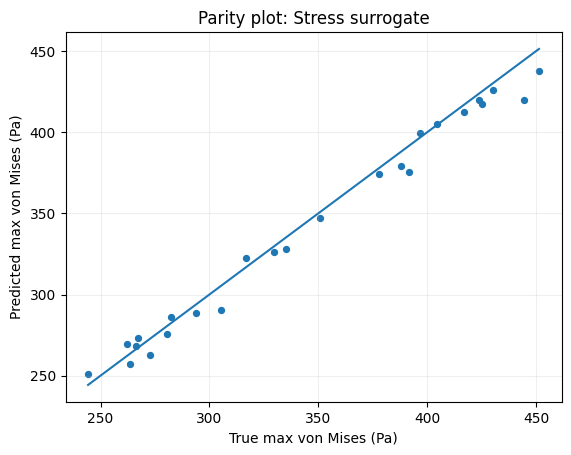


Classification via regression+threshold:
Accuracy: 1.0
[[ 7  0]
 [ 0 18]]
              precision    recall  f1-score   support

        FAIL       1.00      1.00      1.00         7
        PASS       1.00      1.00      1.00        18

    accuracy                           1.00        25
   macro avg       1.00      1.00      1.00        25
weighted avg       1.00      1.00      1.00        25


Direct classification (Logistic Regression):
Accuracy: 1.0
[[ 7  0]
 [ 0 18]]
              precision    recall  f1-score   support

        FAIL       1.00      1.00      1.00         7
        PASS       1.00      1.00      1.00        18

    accuracy                           1.00        25
   macro avg       1.00      1.00      1.00        25
weighted avg       1.00      1.00      1.00        25



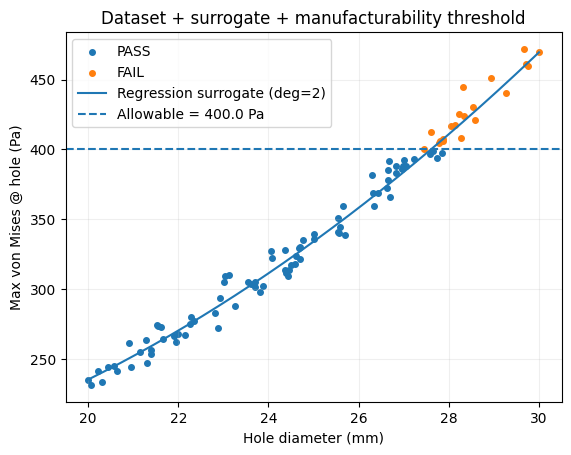


Predictions on new diameters:
   hole_d_mm  pred_mises_pa  pred_manufacturable pred_label
0       21.0     251.973904                    1       PASS
1       23.0     290.039917                    1       PASS
2       26.0     358.163409                    1       PASS
3       29.0     439.516270                    0       FAIL

Saved files:
 - synthetic_hole_stress_dataset_100.csv
 - manufacturability_predictions.csv


In [2]:
# ============================================================
# Colab-ready script: Generate 100-sample dataset (synthetic)
# + ML surrogate to predict von Mises stress
# + Manufacturability (PASS/FAIL) based ONLY on stress threshold
#
# Seeded + reproducible.
# Keeps your 3 anchor cases EXACTLY:
#   (20 mm -> 235 Pa), (25 mm -> 336 Pa), (30 mm -> 470 Pa)
# ============================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import (
    mean_absolute_error, mean_squared_error, r2_score,
    confusion_matrix, classification_report, accuracy_score
)

# -------------------------
# 0) Your 3 anchor cases (kept exactly)
# -------------------------
anchors = pd.DataFrame({
    "case": [1, 2, 3],
    "hole_d_mm": [20.0, 25.0, 30.0],
    "mises_pa": [235.0, 336.0, 470.0]   # case1 is "given", others are your estimates
})

# -------------------------
# 1) Generate synthetic dataset of 100 samples
# -------------------------
N = 100
d_min, d_max = 20.0, 30.0

rng = np.random.default_rng(42)

# Create 97 random diameters + include the 3 anchor diameters
d_random = rng.uniform(d_min, d_max, size=N - len(anchors))
d_all = np.concatenate([anchors["hole_d_mm"].values, d_random])

# "Ground-truth" stress model used to generate synthetic labels:
# Fit a quadratic through the 3 anchors (exact interpolation).
coef = np.polyfit(anchors["hole_d_mm"], anchors["mises_pa"], deg=2)
poly = np.poly1d(coef)

# Add small noise to the 97 synthetic points, but keep anchors noise-free
noise_sigma_pa = 8.0  # tune: larger => harder ML problem
mises_all = poly(d_all)
mises_all[3:] = mises_all[3:] + rng.normal(0, noise_sigma_pa, size=N - 3)  # noise only on non-anchors

# Assemble dataframe, keep anchors as cases 1..3
df = pd.DataFrame({
    "case": np.arange(1, N + 1),
    "hole_d_mm": d_all,
    "mises_pa": mises_all
})

# Overwrite first 3 rows to guarantee exact anchors and labels
df.loc[0, ["hole_d_mm", "mises_pa"]] = [20.0, 235.0]
df.loc[1, ["hole_d_mm", "mises_pa"]] = [25.0, 336.0]
df.loc[2, ["hole_d_mm", "mises_pa"]] = [30.0, 470.0]

# Optional: shuffle rows AFTER preserving anchor presence (anchors stay in dataset, not necessarily top rows)
df = df.sample(frac=1.0, random_state=42).reset_index(drop=True)

print("Synthetic dataset preview:")
print(df.head(10))

# -------------------------
# 2) Define manufacturability criterion (ONLY stress threshold)
# -------------------------
allowable_stress_pa = 400.0  # PASS if mises <= allowable
df["manufacturable"] = (df["mises_pa"] <= allowable_stress_pa).astype(int)  # 1=PASS, 0=FAIL

# -------------------------
# 3) Train/test split
# -------------------------
X = df[["hole_d_mm"]].values
y_reg = df["mises_pa"].values
y_clf = df["manufacturable"].values

X_train, X_test, y_reg_train, y_reg_test, y_clf_train, y_clf_test = train_test_split(
    X, y_reg, y_clf, test_size=0.25, random_state=42
)

# -------------------------
# 4) Regression surrogate: predict stress from diameter
# -------------------------
reg_model = Pipeline([
    ("poly", PolynomialFeatures(degree=2, include_bias=False)),
    ("lr", LinearRegression())
])

reg_model.fit(X_train, y_reg_train)
y_reg_pred = reg_model.predict(X_test)

mae = mean_absolute_error(y_reg_test, y_reg_pred)
# Fix: remove squared=False and take square root for RMSE
rmse = np.sqrt(mean_squared_error(y_reg_test, y_reg_pred))
r2 = r2_score(y_reg_test, y_reg_pred)

print("\nRegression performance (stress prediction):")
print(f"MAE  : {mae:.3f} Pa")
print(f"RMSE : {rmse:.3f} Pa")
print(f"R^2  : {r2:.3f}")

# Parity plot (stress)
plt.figure()
plt.scatter(y_reg_test, y_reg_pred, s=18)
lo, hi = min(y_reg_test.min(), y_reg_pred.min()), max(y_reg_test.max(), y_reg_pred.max())
plt.plot([lo, hi], [lo, hi])
plt.xlabel("True max von Mises (Pa)")
plt.ylabel("Predicted max von Mises (Pa)")
plt.title("Parity plot: Stress surrogate")
plt.grid(True, alpha=0.2)
plt.show()

# -------------------------
# 5) Manufacturability prediction (classification)
# Two ways:
#   A) Threshold the REGRESSION prediction (physics-consistent)
#   B) Train a classifier directly (Logistic Regression)
# We'll do both so you can compare.
# -------------------------

# A) Regression -> threshold
y_clf_pred_from_reg = (reg_model.predict(X_test) <= allowable_stress_pa).astype(int)

print("\nClassification via regression+threshold:")
print("Accuracy:", accuracy_score(y_clf_test, y_clf_pred_from_reg))
print(confusion_matrix(y_clf_test, y_clf_pred_from_reg))
print(classification_report(y_clf_test, y_clf_pred_from_reg, target_names=["FAIL", "PASS"]))

# B) Direct classifier (logistic, using only hole_d_mm)
clf_model = Pipeline([
    ("poly", PolynomialFeatures(degree=2, include_bias=False)),
    ("logreg", LogisticRegression(max_iter=500))
])

clf_model.fit(X_train, y_clf_train)
y_clf_pred = clf_model.predict(X_test)

print("\nDirect classification (Logistic Regression):")
print("Accuracy:", accuracy_score(y_clf_test, y_clf_pred))
print(confusion_matrix(y_clf_test, y_clf_pred))
print(classification_report(y_clf_test, y_clf_pred, target_names=["FAIL", "PASS"]))

# -------------------------
# 6) Visualization: Stress vs diameter + threshold + PASS/FAIL
# -------------------------
d_grid = np.linspace(d_min, d_max, 250).reshape(-1, 1)
stress_grid = reg_model.predict(d_grid)

plt.figure()
# color by manufacturability
mask_pass = df["manufacturable"] == 1
plt.scatter(df.loc[mask_pass, "hole_d_mm"], df.loc[mask_pass, "mises_pa"], s=16, label="PASS")
plt.scatter(df.loc[~mask_pass, "hole_d_mm"], df.loc[~mask_pass, "mises_pa"], s=16, label="FAIL")
plt.plot(d_grid, stress_grid, label="Regression surrogate (deg=2)")
plt.axhline(allowable_stress_pa, linestyle="--", label=f"Allowable = {allowable_stress_pa} Pa")
plt.xlabel("Hole diameter (mm)")
plt.ylabel("Max von Mises @ hole (Pa)")
plt.title("Dataset + surrogate + manufacturability threshold")
plt.grid(True, alpha=0.2)
plt.legend()
plt.show()

# -------------------------
# 7) Predict on new diameters
# -------------------------
query = np.array([21.0, 23.0, 26.0, 29.0]).reshape(-1, 1)
pred_stress = reg_model.predict(query)
pred_pass = (pred_stress <= allowable_stress_pa).astype(int)

pred_df = pd.DataFrame({
    "hole_d_mm": query.flatten(),
    "pred_mises_pa": pred_stress,
    "pred_manufacturable": pred_pass
})
pred_df["pred_label"] = pred_df["pred_manufacturable"].map({1: "PASS", 0: "FAIL"})

print("\nPredictions on new diameters:")
print(pred_df)

# -------------------------
# 8) Save the synthetic dataset + predictions (optional)
# -------------------------
df.to_csv("synthetic_hole_stress_dataset_100.csv", index=False)
pred_df.to_csv("manufacturability_predictions.csv", index=False)

print("\nSaved files:")
print(" - synthetic_hole_stress_dataset_100.csv")
print(" - manufacturability_predictions.csv")
